In [2]:
import cv2 as cv2
import numpy as np
import urllib
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# // 비교 알고리즘의 이름들을 리스트에 저장
methods = ['CORREL',  # cv2.HISTCMP_CORREL: 상관관계 (1: 완전 일치, -1: 완전 불일치, 0: 무관계)
           'CHISQR',  # cv2.HISTCMP_CHISQR: 카이제곱 (0: 완전 일치, 무한대: 완전 불일치)
           'INTERSECT',  # cv2.HISTCMP_INTERSECT: 교차 (1: 완전 일치, 0: 완전 불일치 - 1로 정규화한 경우)
           'BHATTACHARYYA',  # cv2.HISTCMP_BHATTACHARYYA 값이 작을수록 유사한 것으로 판단
           'EMD'
           ]

mission = "https://findspot.s3.ap-northeast-2.amazonaws.com/static/40942aa9-02f1-4ab5-a483-2163b7c6c45c.png"
success = "https://findspot.s3.ap-northeast-2.amazonaws.com/static/9d3276c2-5aca-4416-bd67-400a8b421f69.png"
fail = "https://findspot.s3.ap-northeast-2.amazonaws.com/static/c802a2c8-3441-4fa8-8c28-448799e4efaa.png"

knn = KNeighborsClassifier(n_neighbors=1)


def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = image[135:330, 130:245].copy()  # 세로, 가로
    return image


def slice_image(img, slice):
    img = cv2.resize(img, [360, 360])
    return img[slice[0]:slice[1], slice[2]:slice[3]]


def check_simular(mission, trial, slice):
    # 이미지 읽어오기
    # imgs = [url_to_image(mission), url_to_image(trial)]
    imgs = [slice_image(mission, slice), slice_image(trial, slice)]

    hists = []
    grays = []
    for img in imgs:
        hists.append(image_to_hsv(img))
        grays.append(image_to_gray(img))

    result = [
        cv2.compareHist(hists[0], hists[1], 0),
        cv2.compareHist(hists[0], hists[1], 2) / np.sum(hists[0]),
        cv2.compareHist(hists[0], hists[1], 3),
        ssim(grays[0], grays[1], full=True)
    ]
    # cv2.HISTCMP_CORREL: 상관관계 (1: 완전 일치, -1: 완전 불일치, 0: 무관계)
    # cv2.HISTCMP_INTERSECT: 교차 (1: 완전 일치, 0: 완전 불일치 - 1로 정규화한 경우)
    # cv2.HISTCMP_BHATTACHARYYA 값이 작을수록 유사한 것으로 판단
    # ssim 1에 근접할 수록 유사한 이미지

    # print(result[0], result[1], result[2], result[3][0])

    return result[0] + result[1] - result[2], result[3][0]


def image_to_hsv(img):
    # BGR 이미지를 HSV 이미지로 변환
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = cv2.resize(hsv, dsize=(360, 360))
    # 히스토그램 연산(파라미터 순서 : 이미지, 채널, Mask, 크기, 범위)
    hist = cv2.calcHist([hsv], [0, 1], None, [360, 360], [0, 360, 0, 360])
    # 정규화(파라미터 순서 : 정규화 전 데이터, 정규화 후 데이터, 시작 범위, 끝 범위, 정규화 알고리즘)
    cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
    # hists 리스트에 저장
    return hist


def image_to_gray(img):
    # // BGR 이미지를 GRAY 이미지로 변환
    img = cv2.resize(img, [360, 360])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

In [3]:
index = ['pha', 'sna', 'sil', 'wel', 'box', 'scr', 'rev']

pha = cv2.imread('image/pha.png', cv2.IMREAD_COLOR)
pha_slice = [130, 230, 120, 300]
pha_s = []
pha_f = []

sna = cv2.imread('image/sna.png')
sna_slice = [100, 290, 120, 360]
sna_s = []
sna_f = []

sil = cv2.imread('image/sil.png')
sil_slice = [160, 230, 170, 360]
sil_s = []
sil_f = []

wel = cv2.imread('image/wel.png')
wel_slice = [130, 260, 0, 160]
wel_s = []
wel_f = []

box = cv2.imread('image/box.png')
box_slice = [130, 280, 0, 180]
box_s = []
box_f = []

scr = cv2.imread('image/scr.png')
scr_slice = [0, 360, 130, 360]
scr_s = []
scr_f = []

rev = cv2.imread('image/rev.png')
rev_slice = [0, 180, 0, 360]
rev_s = []
rev_f = []

data = [pha_s, pha_f, sna_s, sna_f, sil_s, sil_f, wel_s, wel_f, box_s, box_f, scr_s, scr_f, rev_s, rev_f]

In [4]:
import os

for i, v in enumerate(index):
    for j in os.listdir('./image/{}/suc'.format(v)):
        data[i * 2].append(cv2.imread('./image/{}/suc/{}'.format(v, j)))
    for j in os.listdir('./image/{}/fail'.format(v)):
        data[i * 2 + 1].append(cv2.imread('./image/{}/fail/{}'.format(v, j)))

In [5]:
x = []
y = []
classes = []


def insert(mission, trial, slice):
    mission = cv2.resize(mission, [360, 360])
    trial = cv2.resize(trial, [360, 360])
    res = check_simular(mission, trial, slice)
    x.append(res[0])
    y.append(res[1])

# insert(mission, mission)
# insert(mission, success)
# insert(mission, fail)

In [6]:
for i, v in enumerate(data):
    for j in v:
        try:
            insert(pha, j, pha_slice)
            if i in [0]:
                classes.append(0)
            else:
                classes.append(1)
        except Exception as e:
            pass

In [7]:
for i, v in enumerate(data):
    for j in v:
        try:
            insert(sna, j, sna_slice)
            if i in [2]:
                classes.append(0)
            else:
                classes.append(1)
        except Exception as e:
            pass

In [8]:
for i, v in enumerate(data):
    for j in v:
        try:
            insert(sil, j, sil_slice)
            if i in [4]:
                classes.append(0)
            else:
                classes.append(1)
        except Exception as e:
            pass

In [9]:
for i, v in enumerate(data):
    for j in v:
        try:
            insert(wel, j, wel_slice)
            if i in [6, 7]:
                classes.append(0)
            else:
                classes.append(1)
        except Exception as e:
            pass

In [10]:
for i, v in enumerate(data):
    for j in v:
        try:
            insert(box, j, box_slice)
            if i in [8, 9]:
                classes.append(0)
            else:
                classes.append(1)
        except Exception as e:
            pass

In [11]:
for i, v in enumerate(data):
    for j in v:
        try:
            insert(scr, j, scr_slice)
            if i in [10]:
                classes.append(0)
            else:
                classes.append(1)
        except Exception as e:
            pass

In [12]:
for i, v in enumerate(data):
    for j in v:
        try:
            insert(rev, j, rev_slice)
            if i in [12, 13]:
                classes.append(0)
            else:
                classes.append(1)
        except Exception as e:
            pass

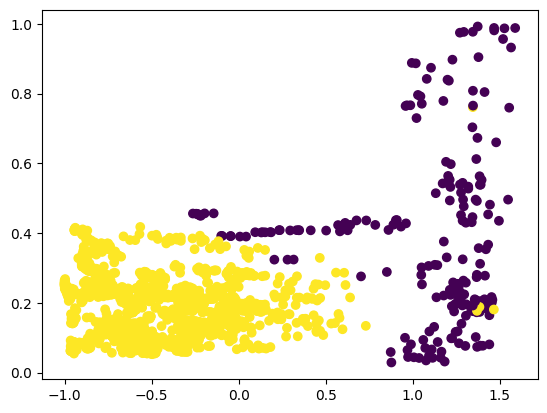

In [13]:
plt.scatter(x, y, c=classes)
plt.show()

In [14]:
predict = knn.fit(list(zip(x, y)), classes)
mission = cv2.resize(pha, [360, 360])
trial = cv2.resize(data[0][12], [360, 360])
res = check_simular(mission, trial, pha_slice)

pred = knn.predict([res])
print(pred)
print(predict.score(X=np.array(list(zip(x, y))), y=classes))

[0]
1.0


In [15]:
from joblib import dump, load

dump(predict, './model/model.joblib')

['./model/model.joblib']

In [16]:
m = load('./model/model.joblib')

In [17]:
print(m.predict([res]))

[0]


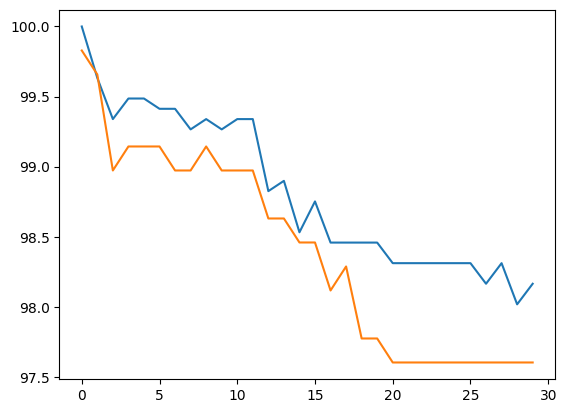

/Users/0bver/project/capstone/imageAnalysis/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


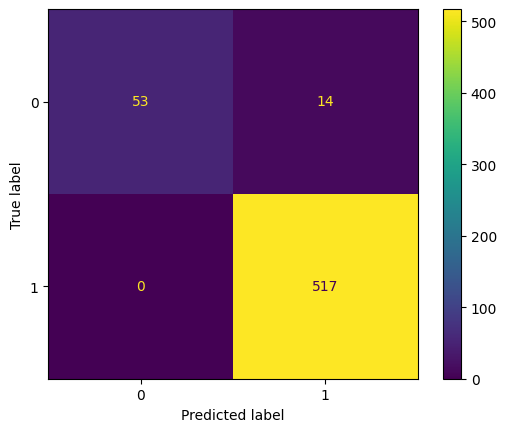

/Users/0bver/project/capstone/imageAnalysis/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


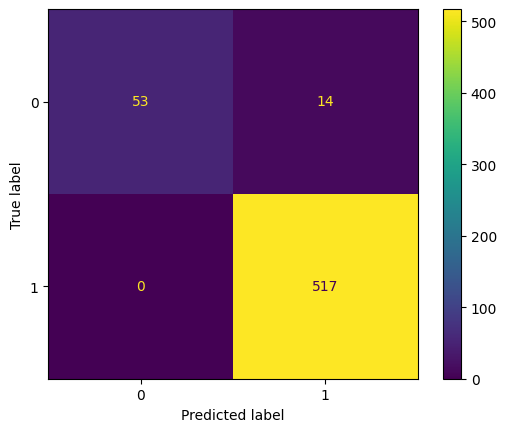

In [18]:
x = list(zip(x, y))
y = classes
train_acc = []
test_acc = []
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

for d in range(1, 31):
    knn = KNeighborsClassifier(d, n_jobs=-1)
    knn.fit(X_train, y_train)
    train_acc.append(knn.score(np.array(X_train), np.array(y_train))*100)
    test_acc.append(knn.score(np.array(X_test), np.array(y_test))*100)
plt.plot(train_acc)
plt.plot(test_acc)
plt.show()

if min(test_acc):
    plot_confusion_matrix(knn, np.array(X_test), np.array(y_test))
    plt.show()

if max(test_acc):
    plot_confusion_matrix(knn, np.array(X_test), np.array(y_test))
    plt.show()

/Users/0bver/project/capstone/imageAnalysis/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


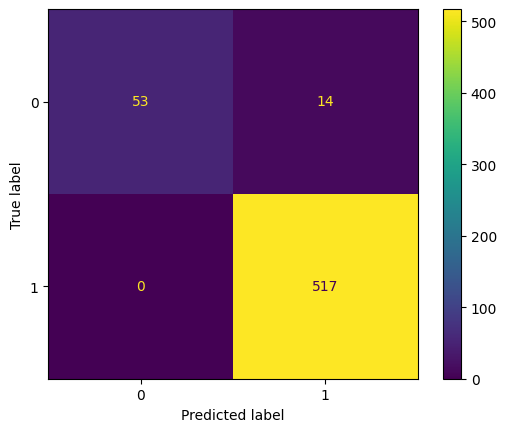

In [19]:
from sklearn.metrics import plot_confusion_matrix

# for i in range(14):
#     for j in range(len(data[i])):
#         mission = cv2.resize(pha, [360, 360])
#         trial = cv2.resize(data[i][j], [360, 360])
#         res = check_simular(mission, trial, pha_slice)
#         pred = knn.predict_proba(np.array([res]))
#         print(f"1: {pred[0][1]}, 0: {pred[0][0]}")
plot_confusion_matrix(knn, np.array(X_test), np.array(y_test))
plt.show()

In [27]:
# mi = cv2.imread('image/IMG_5200.JPG')
# tr = cv2.imread('image/IMG_5209.JPG')

mi = cv2.imread('image/scr1.png')
tr = cv2.imread('image/scr2.png')
# cv2.imshow("mi", mi)
# cv2.waitKey(0)
res = check_simular(mi, tr, [0, 360, 0, 360])
# res = check_simular(mi, tr, [50,310, 50,310])

pred = knn.predict_proba([res])
print(pred)
# print(predict.score(X=np.array(list(zip(x, y))), y=classes))

[[0.96666667 0.03333333]]


In [28]:
res

(1.8978193612807817, 0.9165229824408497)